# Modeling a Torque-Free Rotating Body in Space
Josh W. Day  
MAE 223 - Multibody Dynamics (Fall 2017)  
Final Project

- *Estimated run-time to completion: **1m 30s***

# 1. Introduction

At this moment in history, mankind is on a precipice as it prepares to swim away from the shores of the cosmic ocean. In order to embark on this journey, we must be prepared to face the plethora of dangers that comes with living in space for an extended period of time - one in particular being the lack of gravity and its effect on the human body. Without the force of gravity acting on us, our bodies slowly deteriorate through decreasing bone density and muscle mass. For short time spans on the order of a year, this is a recoverable condition - however, beyond that, the effects begin to become more and more detrimental. If we are to begin thinking seriously about sending people to places beyond the moon or Mars, a viable method must be developed to simulate gravity for astronauts. One of the oldest and most-often considered methods is to use an enclosed, symmetric environment and allow it to rotate along a central axis to create a *rotogravic environment* on the interior - one that feigns a gravitational force via an individual's inertia in an inertial reference frame, or *centrifugal force*.


The idea is prevalent both in academic literature and fiction alike, and while this report will make no attempt to solve *all* the problems associated with attempting such a monumental engineering feat (there are many), it will demonstrate this student's attempt to model and simulate the dynamic motion of one configuration in particular, specifically to become familiar with how the motion of the system will be affected by the motion of hypothetical astronauts, equipment, etc. within the confines of the station.

The original objective set out to be accomplished would seen the formulation of an active controller which would work to control the position of "ballast" masses located on the circumference of the station in order to balance out any shifts in mass due to the aforementioned motion of people, equipment, etc. within the station, as shown in Figure 1 below.


![](SysOutline1.PNG)

The inspiration for this project stemmed from an idea involving water or some other fluid stored along the circumference to act as a passive mass balancing system and motion damper, however that was deemed to lie beyond the scope of this project, and a simpler system was examined instead.



# 2. Formulation

The system is modeled as a simple torus with major diameter significantly larger than inner tube diameter, fixed to a body frame *B*. Three rotations are required in order to orient to the body-fixed axes, and the order of rotation will certainly affect the interpretations of the results. As is generally well-known, two separate rotations performed around X then Y are not necessarily equal to the same rotations performed about Y then X axes. Therefore, it is necessary to pay close attention to which generalized coordinate revolves the reference frame about which axis.

The mass of all the system components are treated as constants, but since the location of each point mass is prescribed through time, the variables that describe the locations must be introduced as *dynamic symbols*.

The formulation of the equations of motions for this system begins as usual with definition of our environment...

In [73]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import matplotlib.pyplot as plt
from pydy.system import System
me.init_vprinting(use_latex=True, pretty_print=False)

%matplotlib widget

...and then defining a few key parameters of our system:
- Station Mass, $m_s$
- Station Radius, $R_s$
- Station Length (in the axisymmetric direction), $L_s$
- Initial angular velocity about axis of symmetry, $\omega_0$

In [74]:
ms, Rs, Ls, w0 = sm.symbols('m_s, R_s, L_s, omega_0')
t = me.dynamicsymbols._t

Next we define dynamic symbols to represent the cartesian locations of interest:
- XYZ locations of the two point masses, and their corresponding mass symbols
- XYZ locations of the two ballast masses, and their corresponding mass symbols

In [75]:
# Measure numbers for vector that locates center of station body relative to CM
# xpbs, ypbs, zpbs = me.dynamicsymbols('x_pbs, y_pbs, z_pbs')

In [76]:
# Measure numbers for vector that locates Point P1 relative to CM, which will later be prescribed as a function of time
mp1 = sm.symbols('m_p1')
xp1, yp1, zp1 = me.dynamicsymbols('x_p1, y_p1, z_p1')

In [77]:
# Measure numbers for vector that locates Point P2 relative to CM, which will later be prescribed as a function of time
mp2 = sm.symbols('m_p2')
xp2, yp2, zp2 = me.dynamicsymbols('x_p2, y_p2, z_p2')

In [78]:
# Measure numbers for vector that locates Point Pblst1 relative to CM, which will later be prescribed as a function of time
mpblst = sm.symbols('m_ballast')
xpblst1, ypblst1, zpblst1 = me.dynamicsymbols('x_p_blst_1, y_p_blst_1, z_p_blst_1')

In [79]:
# Measure numbers for vector that locates Point P2 relative to CM, which will later be prescribed as a function of time
xpblst2, ypblst2, zpblst2 = me.dynamicsymbols('x_p_blst_2, y_p_blst_2, z_p_blst_2')

## 2.1 Generalized Coordinates
- q1: Angle of rotation of intermediate RF N' about N.x axis
- q2: Angle of rotation of intermediate RF N'' about N'.y axis
- q3: Angle of rotation of body-fixed RF B about N''.z axis

In [80]:
q1, q2, q3 = me.dynamicsymbols('q1 q2 q3')

## 2.2 Generalized Speeds
All generalized speeds are defined by the trivial definition, e.g. the derivatives of the generalized coordinates

In [81]:
u1, u2, u3 = me.dynamicsymbols('u1 u2 u3')

## 2.3 Reference Frames
This is where things can get interesting. Depending on how on chooses to perform their body transformation, they will be required to interpret their results differently. Iteration and multiple trials led to using a simple Tait-Bryan XYZ transformation for this project due to a tendency for Euler transformations to result in a singularity (gimbal lock).

In [82]:
N = me.ReferenceFrame('N')
B = N.orientnew('B', 'Body', [q1, q2, q3], 'XYZ')

We should take care to remember from this point forward is that the angle $q_1$ is not measured directly from the body-fixed RF B, and instead is transformed through the intermediate RF N''.

## 2.4 Kinematic Differential Equations

In [83]:
kdes = [u1 - q1.diff(),
        u2 - q2.diff(),
        u3 - q3.diff()]

In [84]:
qdots = sm.solve(kdes, q1.diff(), q2.diff(), q3.diff())

## 2.5 Substitute in the Generalized Speeds

In [85]:
w_B_N = B.ang_vel_in(N).subs(qdots).simplify()
B.set_ang_vel(N, w_B_N)

## 2.6 Points (Positions of which are Specified Inputs)

In [86]:
O = me.Point('O')  # Point of origin at CM

##### - IMPORTANT -
The CM stays fixed at Point O. They are one and the same. As mass moves around by prescribed motion, the station also moves in reaction such that the CM of the *system* stays fixed in space

In [87]:
P1_loc_PBs = xp1*B.x + yp1*B.y + zp1*B.z  # Vector to locate Point P1 from Body Center of Station
P2_loc_PBs = xp2*B.x + yp2*B.y + zp2*B.z  # Vector to locate Point P2 from Body Center of Station

Pblst1_loc_PBs = xpblst1*B.x + ypblst1*B.y + zpblst1*B.z  # Vector to locate Point Ballast 1 from O
Pblst2_loc_PBs = xpblst2*B.x + ypblst2*B.y + zpblst2*B.z  # Vector to locate Point Ballast 2 from O

# Vector to locate Body Geometric Center from CM (since CM is fixed in space)
# Can also be considered the negative of location of CM from Body Geometric Center
PBs_loc_CM = -(mp1*P1_loc_PBs + mp2*P2_loc_PBs + mpblst*(Pblst1_loc_PBs + Pblst2_loc_PBs))/(mp1+mp2+(2*mpblst)+ms)

P1_loc_CM = P1_loc_PBs + PBs_loc_CM # Vector to locate Point P1 from CM
P2_loc_CM = P2_loc_PBs + PBs_loc_CM  # Vector to locate Point P2 from CM

Pblst1_loc_CM = Pblst1_loc_PBs + PBs_loc_CM  # Vector to locate Point Ballast 1 from Body Center of Station
Pblst2_loc_CM = Pblst2_loc_PBs + PBs_loc_CM  # Vector to locate Point Ballast 2 from Body Center of Station

In [88]:
P1 = O.locatenew('P_1', P1_loc_CM)
P1.set_vel(B, 0)
P1.set_vel(N, B.ang_vel_in(N).cross(P1_loc_CM))

In [89]:
P2 = O.locatenew('P_2', P2_loc_CM)
P2.set_vel(B, 0)
P2.set_vel(N, B.ang_vel_in(N).cross(P2_loc_CM))

In [90]:
Pblst1 = O.locatenew('P_ballast_1', Pblst1_loc_CM)
Pblst1.set_vel(B, 0)
Pblst1.set_vel(N, B.ang_vel_in(N).cross(Pblst1_loc_CM))

In [91]:
Pblst2 = O.locatenew('P_ballast_2', Pblst2_loc_CM)
Pblst2.set_vel(B, 0)
Pblst2.set_vel(N, B.ang_vel_in(N).cross(Pblst2_loc_CM))

In [92]:
PBs = O.locatenew('P_B_s', PBs_loc_CM)
PBs.set_vel(B, 0)
PBs.set_vel(N, B.ang_vel_in(N).cross(PBs_loc_CM))

## 2.7 Mass and Inertia

In [93]:
# Moment of Inertia of station in RF B
Is = me.inertia(B, (ms/12)*(3*Rs**2 + Ls**2), (ms/12)*(3*Rs**2 + Ls**2), ms*Rs**2)

station = me.RigidBody('station', PBs, B, ms, (Is, PBs))

point1 = me.Particle('point1', P1, mp1)
point2 = me.Particle('point2', P2, mp2)
ballast1 = me.Particle('ballast1', Pblst1, mpblst)
ballast2 = me.Particle('ballast2', Pblst2, mpblst)

## 2.8 Kane's Method
With all parts of the system defined as was described earlier, we can call *me.KanesMethod* to formulate the dynamic equations $F + F^* = 0$

In [94]:
bodies = [station, point1, point2, ballast1, ballast2]
loads = None

In [95]:
kane = me.KanesMethod(N,
                      q_ind=(q1, q2, q3),
                      u_ind=(u1, u2, u3),
                      kd_eqs=kdes)

In [96]:
fr, frstar = kane.kanes_equations(bodies, loads)

In [97]:
me.find_dynamicsymbols(frstar)

What's interesting to note here is that $f_r$ and $f_r^*$ come to what we would expect:
- $f_r = [0]$, as there are no forcing external forces acting on the system
- $f_r^*$ is **NOT** a function of $q_1$. This result would be expected in a 'ZYX' transformation since the orientation of the station about its axis of symmetry should not affect the dynamics of the system (assuming symmetry of mass distribution as well). However, upon changing the rotation transformation style to something such as 'XYZ', we find that the system is *still not a function of $q_1$*, despite the fact that $q_1$ should now correspong to rotation about the inertial X axis.

This discrepency was went completely unnoticed until the day of submission of this report, and therefore further exploration (and the possibility that it may affect the outcome of attempting to linearize the system) must be performed at a later time.

# 3. Simulation

Before simulating, we need to specify a range of times to integrate over and system parameters (constants and initial conditions), followed by a function that will prescribe the location of the point masses through time.
**- Note -** The masses ascribed here are NOT representative of a realistic station-astronaut(s) system. This system was designed in order to exaggerate the dynamical effects of such a system. Realistically, the perturbations would be much smaller considering the scales we are working with here.

## 3.1 Simulation Setup
We require five parameters in order to simulate:
1. Dynamic equations, as derived in the previous section
2. A range of time steps
3. Simulation constants (i.e. masses, radii, etc.)
4. Initial conditions
5. Specified parameters (essentially, this is our door into the integration routine. Through 'specifieds' we specify positions of the masses. More importantly, we can specify how they change over time.)

### 3.1.1 Time Step, Constants, Init Conditions

In [103]:
times = np.linspace(0.0, 20.0, num=900)

constants = {ms: 1000,
             Rs: 10,
             Ls: 1,
             mp1: 50,
             mp2: 50,
             mpblst: 100}

init_cond = {q1: 0,
             q2: 0,
             q3: 0,
             u1: 0,
             u2: 0,
             u3: 1}

127.0.0.1 - - [09/Dec/2020 15:26:38] "GET /css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 15:26:39] "GET /js/dyviz/main.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 15:26:39] "GET /2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 15:26:39] code 404, message File not found
127.0.0.1 - - [09/Dec/2020 15:26:39] "GET /fonts/glyphicons-halflings-regular.woff2 HTTP/1.1" 404 -
127.0.0.1 - - [09/Dec/2020 15:26:40] "GET /2020-12-09_14-16-04_simulation_data.json HTTP/1.1" 304 -
127.0.0.1 - - [09/Dec/2020 15:30:20] code 404, message File not found
127.0.0.1 - - [09/Dec/2020 15:30:20] "GET /fonts/glyphicons-halflings-regular.woff2 HTTP/1.1" 404 -
127.0.0.1 - - [09/Dec/2020 15:30:20] "GET /index.html?load=2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 15:30:30] "GET /2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 15:30:30] code 404, message File not found
127.0.0.1 - - [09/Dec/2020 15:30

### 3.1.2 Specified Parameters
The method to prescribe the location of the points masses is "point_motion()". As it is currently written, Particle motion will begin 5 seconds into the simulation, last for 10 seconds, then freeze. Currently, the Ballast masses are fixed in their respective locations because no constraint equations have been written to specify their motion. Their coordinates are prescribed in the station body reference frame 'B'.

In [100]:
def point_motion(x, t, Rs=constants[Rs]):
    if t < 5:
        xp1 = 0
        yp1 = Rs
        zp1 = 0
        
        xp2 = 0
        yp2 = -Rs
        zp2 = 0
    
    elif t >= 5 and t < 15:
        xp1 = Rs*np.cos((np.pi/2)*(1 - ((t-5)/10)))
        yp1 = Rs*np.sin((np.pi/2)*(1 - ((t-5)/10)))
#         zp1 = 5*(t-5)/10    # Only useful if you want to see how out-of-plane motion point-mass motion affects overall motion
        zp1 = 0

        xp2 = Rs*np.cos((np.pi/2)*(1 - ((t-5)/10)))
        yp2 = -Rs*np.sin((np.pi/2)*(1 - ((t-5)/10)))
#         zp2 = 0.8*(t-5)/10    # Only useful if you want to see how out-of-plane motion point-mass motion affects overall motion
        zp2 = 0
    
    else:
        xp1 = Rs
        yp1 = 0
        zp1 = 0

        xp2 = Rs
        yp2 = 0
        zp2 = 0

    xpblst1 = -Rs
    ypblst1 = 0
    zpblst1 = 0
    xpblst2 = Rs
    ypblst2 = 0
    zpblst2 = 0
        
    return np.array([xp1, yp1, zp1, xp2, yp2, zp2, xpblst1, ypblst1, zpblst1, xpblst2, ypblst2, zpblst2])

specifieds = {(xp1, yp1, zp1, xp2, yp2, zp2, xpblst1, ypblst1, zpblst1, xpblst2, ypblst2, zpblst2): point_motion}

### 3.1.3 Initialize
With the system parameters defined, we can define our whole system by packaging it all together.

In [44]:
sys = System(kane,
             constants=constants,
             specifieds=specifieds,            # This must be a dict object that contains entries, but an entry can be a function!
             initial_conditions=init_cond,
             times=times)

### 3.1.4 Integrate

In [45]:
traj = sys.integrate()

### 3.1.5 Results
Instantiate a matplotlib widget to plot the states vs. time

In [46]:
%matplotlib widget

In [47]:
states = [q1, q2, q3, u1, u2, u3]
fig, axes = plt.subplots(6, 1)

for i, ax in enumerate(axes):
    ax.plot(times, traj[:, i]*180/np.pi)
    ax.set_ylabel(sm.latex(states[i], mode='inline'))

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Note** that angles and angular rates are in degrees and degrees/sec, respectively

# 4. 3D Visualization
We're going to use the pydy.viz package to simulate the system. We'll need to import all the shapes we want to use (Torus, Cylinder, Sphere) and a few other items. Due to the fact that "scene" cannot be passed any aguments that contain symbols, and due to the fact that we can't access the state symbols directly from 'sys', we have to create the "scene" object by explicitly specifying all of the parameters when calling the method. In order to determine these parameters as a they vary in time, we must call them again, this time *outside* the integration loop, and save the output to temporary values.

In [48]:
from pydy.viz import Torus, Cylinder, Sphere, Tube, VisualizationFrame, Scene

In [49]:
# Ballast point motions (all static for now)
ballast1 = np.ones((len(times), 1))*-constants[Rs]
ballast2 = np.zeros((len(times), 2))
ballast3 = np.ones((len(times), 1))*constants[Rs]
ballast4 = np.zeros((len(times), 2))

ballast_traj = np.append(np.append(np.append(ballast1, ballast2, axis=1), ballast3, axis=1), ballast4,axis=1)

In [50]:
# Tack on the point mass motions (copied from def_motion)
traj_pms = np.zeros((len(times), 6))

for k in range(len(times)):
    t = times[k]
    if t < 5:
        traj_pms[k, 0] = 0  # xp1
        traj_pms[k, 1] = constants[Rs]  # yp1
        traj_pms[k, 2] = 0  # zp1
        
        traj_pms[k, 3] = 0  # xp2
        traj_pms[k, 4] = -constants[Rs]  # yp2
        traj_pms[k, 5] = 0  # zp2
    
    elif t >= 5 and t < 15:
        traj_pms[k, 0] = constants[Rs]*np.cos((np.pi/2)*(1 - ((t-5)/10)))
        traj_pms[k, 1] = constants[Rs]*np.sin((np.pi/2)*(1 - ((t-5)/10)))
#         traj_pms[k, 2] = 5*(t-5)/10   # Only useful if you want to see how out-of-plane motion point-mass motion affects overall motion
        traj_pms[k, 2] = 0

        traj_pms[k, 3] = constants[Rs]*np.cos((np.pi/2)*(1 - ((t-5)/10)))
        traj_pms[k, 4] = -constants[Rs]*np.sin((np.pi/2)*(1 - ((t-5)/10)))
#         traj_pms[k, 5] = 0.8*(t-5)/10    # Only useful if you want to see how out-of-plane motion point-mass motion affects overall motion
        traj_pms[k, 5] = 0
    
    else:
        traj_pms[k, 0] = constants[Rs]
        traj_pms[k, 1] = 0
        traj_pms[k, 2] = 0

        traj_pms[k, 3] = constants[Rs]
        traj_pms[k, 4] = 0
        traj_pms[k, 5] = 0
        
traj_all = np.append(traj, np.append(traj_pms, ballast_traj, axis=1), axis=1)

Now that we've re-captured the parameters of interest, we can set up the animation by placing colored spheres for each point. The Point Masses are represented by red spheres while the Ballast Masses are represented by green spheres.

In [51]:
pm1_sph = Sphere(0.5, color='red')                # Point-mass 1
pm2_sph = Sphere(0.5, color='red')                # Point-mass 2
pblst1_sph = Sphere(0.75, color='green')          # Ballast point-mass 1
pblst2_sph = Sphere(0.75, color='green')          # Ballast point-mass 2
torus_s = Torus(10, 0.5, 8, 100, color='blue')    # The torus-shaped 'space station'. Unfortunately, despite my best efforts, I cannot seem to modify the default number of ring segments (6). So our 'ring-shaped space station' will be represented by a hexagon.
w_vector = Cylinder(10, 0.1, color='magenta')     # A rod fixed to the geometric center of the torus to help us see when it starts to go off-kilter

In [52]:
Bz = B.orientnew('Bz', 'Axis', [np.pi/2, B.x])

In [58]:
vf1 = VisualizationFrame('P_1', B, P1, pm1_sph)
vf2 = VisualizationFrame('P_2', B, P2, pm2_sph)
vfbp1 = VisualizationFrame('Pblst_1', B, Pblst1, pblst1_sph)
vfbp2 = VisualizationFrame('Pblst_2', B, Pblst2, pblst2_sph)
vfvec = VisualizationFrame('w_vector', Bz, PBs.locatenew('y', 5 * Bz.y), w_vector)
vftor = VisualizationFrame('station', B, PBs, torus_s)

In [59]:
states = sys.states
points_pos = [xp1, yp1, zp1, xp2, yp2, zp2]
ballast_pos = [xpblst1, ypblst1, zpblst1, xpblst2, ypblst2, zpblst2]

In [60]:
states_symbols = states + points_pos + ballast_pos

In [61]:
scene = Scene(N, O, vf1, vf2, vfbp1, vfbp2, vfvec, vftor, times=times, constants=constants, states_symbols=states_symbols, states_trajectories=traj_all)

...aaaaaaand go!  
**Note:** The 3D visualization begins zoomed IN to the point where the torus is not visible. Once it appears everyting has loaded, zoom out a few ticks before pressing 'Play'

In [62]:
scene.display()
# Takes a minute to execute, be patient. Once the visualization server has started, open the .json file to view the animation.

/home/josh/sympy-rotating-torus/pydy-resources/pydy-resources/pydy-resources
Serving HTTP on 127.0.0.1 port 8002 ...
To view visualization, open:

http://localhost:8002/index.html?load=2020-12-09_14-16-04_scene_desc.json
Press Ctrl+C to stop server...


127.0.0.1 - - [09/Dec/2020 14:16:11] "GET /index.html?load=2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:11] "GET /js/external/utils/bootstrap-slider.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:11] "GET /js/dyviz/param_editor.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:11] "GET /js/dyviz/materials.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:11] "GET /js/dyviz/main.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:12] "GET /2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:12] code 404, message File not found
127.0.0.1 - - [09/Dec/2020 14:16:12] "GET /fonts/glyphicons-halflings-regular.woff2 HTTP/1.1" 404 -
127.0.0.1 - - [09/Dec/2020 14:16:12] "GET /2020-12-09_14-16-04_simulation_data.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 14:16:27] "GET /2020-12-09_14-16-04_scene_desc.json HTTP/1.1" 304 -
127.0.0.1 - - [09/Dec/2020 14:16:27] code 404, message File not found
127.0.0.1 - - [09/Dec

# 5. Linearize
What lies below is an initial attempt at linearizing the system as a first step toward building a controller to control the Ballast masses. Linearization takes place about an operating point, which in this case, is the "balanced" system (C.M. located at geometric center of torus).

In [ ]:
point_states = {xp1: 0, yp1: Rs, zp1: 0,
                xp2: 0, yp2:-Rs, zp2: 0,
                xp1.diff(): 0, yp1.diff(): 0, zp1.diff(): 0,
                xp2.diff(): 0, yp2.diff(): 0, zp2.diff(): 0,
                xpblst1:-Rs, ypblst1: 0, zpblst1: 0,
                xpblst2: Rs, ypblst2: 0, zpblst2: 0,
                xpblst1.diff(): 0, ypblst1.diff(): 0, zpblst1.diff(): 0,
                xpblst2.diff(): 0, ypblst2.diff(): 0, zpblst2.diff(): 0}

In [ ]:
v0 = sm.zeros(8, 1)
v0[2] = 0.1  # Assign 0.1 to u3's zeroing point (the angular velocity about Body-frame B.z axis)

In [ ]:
v = sm.Matrix([q2, q3, u1, u2, u3, u1.diff(), u2.diff(), u3.diff()])
#v = sm.Matrix([q1, q2, q3, u1, u2, u3, u1.diff(), u2.diff(), u3.diff(), xpblst1, ypblst1, zpblst1, xpblst2, ypblst2, zpblst2])

In [46]:
v_subs = dict(zip(v, v0))

In [47]:
frstar = frstar.subs(constants).subs(point_states).subs({Rs: 10})
f_lin = frstar.subs(v_subs) + frstar.jacobian(v).subs(v_subs) * (v - v0)

In [48]:
q = sm.Matrix([q2, q3])
u = sm.Matrix([u1, u2, u3])

In [49]:
K = f_lin.jacobian(q)

In [50]:
C = f_lin.jacobian(u)

In [51]:
M = f_lin.jacobian(u.diff())

In [52]:
F = f_lin - M * u.diff() - C * u - K * q

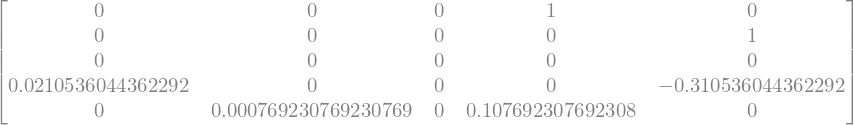

In [53]:
Astate = sm.zeros(2, 3).row_join(sm.eye(2)).col_join(-M.LUsolve(K).row_join(-M.LUsolve(C)))
Astate

The state matrix A shown above *supposedly* represents the linearized system about a zero operating point, although it would seem that something may be in error. It is at this point where more time beyond the limited amount available for this project must be used to figure out the linearization process.

# 6. Conclusion

The initial objective of this project proved to be far loftier than initially expected, and unfortunately only a portion of the objectives were obtained. An analogous system consisting of multiple point masses, some of which are prescribed motion in time, was formed and equations of motion derived using Kane's Method, followed by simulating, plotting the state vectors through time, and visualizing the motion using 3D shapes. Various body transformation methods were explored to determine the most suitable choice of transformations to intuit the state of the system from the state vectors alone. A controller design was attempted but ultimately was not completed due to a seemingly erroneous linearization of the state space. Though incomplete, we can still claim with confidence that the non-linear equations of motion derived using Kane's Method accurately described the motion of the system as we would expect it to behave.

Future work should strive to *properly* linearize the system, or alternatively, attempt to design a controller around a non-linear plant. Following that, the interaction between the point masses and the station can be modeled to account for action/reactions such as those that take place as a human walks along a surface. Further work could be done to account for various external forces such as solar wind, gravitational gradients acting radially outward from any nearby cellestial bodies, and aerodynamic drag (if the station were assumed to be in low-Earth Orbit).